In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf


import pymc3
import  logistic
import run_covering_2
import warnings
warnings.filterwarnings('ignore')

import groups_tools as gid #the important homemade module

%load_ext autoreload
%autoreload 2

# Initial setups

In [367]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=16
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['axes.linewidth']=2.0
plt.rcParams['image.interpolation']='none'
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4.0
plt.rcParams['ytick.major.size']=8.0
plt.rcParams['legend.numpoints']=1
plt.rcParams['image.origin']='lower'
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Computer Modern'

In [3]:
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelleft']= True
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.major.size']=8
plt.rcParams['ytick.left']= True
plt.rcParams['ytick.major.left']= True

# Data imports

In [4]:
G = pd.read_csv("G_referee_modif.csv", index_col = False)
R = pd.read_csv("R_referee_modif.csv", index_col = False)

In [5]:
Abs = pd.read_csv("MgII_all_absorption")
fields_info = pd.read_csv("fields_info_ebv.csv")

### Number of galaxies (for the article)

In [6]:
R["QSO_is_behind"] = (R["zqso_sdss_x"] >= R["Z"] + 3e6/const.c.value)
Rok = R[R["QSO_is_behind"]==True]
len(Rok)

1210

# column densities

In [7]:
G["NHI"], G["sigma_NHI"] = gid.Fukugita(G["REW_2796"], G["sig_REW_2796"], G["center_z"])
G["NHI_limit"], _ = gid.Fukugita(G["detection_limit"], 1, G["center_z"])

# Halo Mass from M*

In [8]:
G["Mhalo"] = gid.Behroozi(np.log10(G["Mstar"]), G["center_z"])

# Vlos min max & spread

In [9]:
for i, g in G.iterrows():
    grpid = g["group_id"]
    rr = R[R["group_id"] == grpid]
    rr = rr[rr["outlier"] == False]
    vmin = rr["vlos_to_gcenter"].min()
    vmax = rr["vlos_to_gcenter"].max()
    zmin = rr["Z"].min()
    zmax = rr["Z"].max()
    vspread = vmax-vmin
    G.loc[i, "vlos_min"] = vmin
    G.loc[i, "vlos_max"] = vmax
    G.loc[i, "z_min"] = zmin
    G.loc[i, "z_max"] = zmax
    G.loc[i, "vlos_spread"] = vspread

# Virial velocity

In [10]:
K = (1*u.kpc).to(u.m)
K.value

3.085677581491367e+19

In [11]:
G["Vvir_sigma2"] = (const.G.value*G["Mvir_sigma2"]*const.M_sun.value/G["Rvir_sigma2"]/K.value)**0.5
G["Vvir_sigma3"] = (const.G.value*G["Mvir_sigma3"]*const.M_sun.value/G["Rvir_sigma3"]/K.value)**0.5
G["Vvir_sigma2"] = G["Vvir_sigma2"]/1000 #back in km/s
G["Vvir_sigma3"] = G["Vvir_sigma3"]/1000 #back in km/s

# Groups selection

In [12]:
G["bool_abs_01"] = (G["REW_2796"] > 0.1)*1
G["bool_abs_03"] = (G["REW_2796"] > 0.3)*1
G["bool_abs_1"] = (G["REW_2796"] > 1)*1

In [13]:
len(G)
len(G[G["N_gal"]>=3])

123

In [14]:
#f1 = G["N100"] <= 1
#f3 = G["N100_los"] <= 2
#f4 = G["N100_los"] <= 1
f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f10 = G["bool_absorption"] == 0
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True
#f24 = G["ID"].isin(good_grp)

f15 = R["B_KPC"] <= 100
f16 = R["N100_los"] <= 2
f17 = R["N100_los"] <= 1
f18 = R["N50_neighb"] == 0
f19 = R["Z"] >= 4700/2796 - 1
f20 = R["Z"] <= 9300/2796 - 1
f21 = R["bool_absorption"] == 0
f22 = R["bool_absorption"] == 1
f23 = R["B_KPC"]>= 5 # remove the QSOs
#fweirds = G["Rvir_recomputed"] >= 10

In [15]:
for c in R.columns:
    print(c)

ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
white_ID
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_i
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
mass_noNA
mass
dist_ang
dist_lum
N100_neighb
N50_neighb
group_id
DMEAN
D12
V12
is_grouped
Mvir_sigma2
Mvir_sigma3
Rvir_sigma2
Rvir_sigma3
mass10
ra_mass
dec_mass
z_mass
Mvir

In [16]:
G_abs = G[f8 & f14 & f13]
G_noabs = G[f10 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[f10 & f7 & f14 & f13]
G5_raw = G[f9]
G5 = G[f9 & f13 & f14]
#G5 = gid.create_id(G5, "N_gal")
G5_abs = G5[G5["bool_absorption"] == 1]
G5_noabs = G5[G5["bool_absorption"] == 0]
G3 = G[f99 & f13 & f14]
G3_abs = G3[G3["bool_absorption"] == 1]
G3_noabs = G3[G3["bool_absorption"] == 0]

R_ilane_abs = R[f22 & f15 & f17 & f18 & f23]
R_ilane_noabs = R[f21 & f15 & f17 & f18  & f23]
R_ilane2_abs = R[f22 & f17 & f18  & f23]
R_ilane2_noabs = R[f21 & f17 & f18  & f23]

The number of groups of more than 5 galaxies is originally:

In [17]:
len(G5_raw)

32

# statistics on absorbers & galaxies

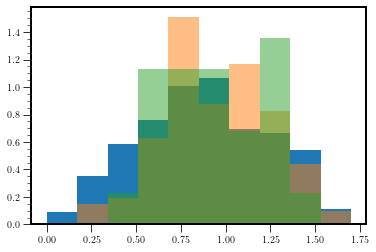

In [18]:
plt.hist(R["Z"], range = (0,1.7), density = True);
plt.hist(Abs["z_abs"], range = (0,1.7), density = True, alpha = 0.5);
plt.hist(G5["center_z"], range = (0,1.7), density = True, alpha = 0.5);

But we have to remove the groups that are behind the QSO:

Finally the number of groups of more than 5 galaxies is:

In [19]:
print("nb of groups of more than 5 gal: ", len(G5))
print("nb of groups of more than 3 gal: ", len(G3))

nb of groups of more than 5 gal:  26
nb of groups of more than 3 gal:  90


### exports the groups

In [20]:
#gid.plot_groups(R, G3, Nmin = 1, save = True,  filename = "FoF_G3_groups_caust.pdf")

# Mass of the groups

In [21]:
print(np.min(np.log10(G5["Mvir_sigma2"])))
print(np.max(np.log10(G5["Mvir_sigma2"])))
print(np.median(np.log10(G5["Mvir_sigma2"])))

10.726187183000865
13.719026815640284
12.346054727074716


In [22]:
print(np.min(G5["center_z"]))
print(np.max(G5["center_z"]))
print(np.median(G5["center_z"]))

0.46399999999999997
1.4322860299315043
0.95621


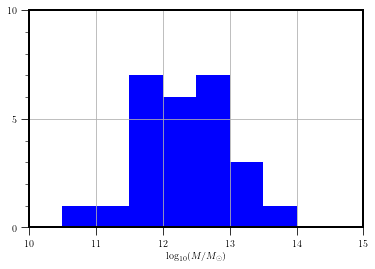

In [23]:
#plt.figure(figsize = (6,4))
plt.hist(np.log10(G5["Mvir_sigma2"]), bins = 10, range=(10, 15), color = "blue");
plt.xlabel("$\log_{10}(M/M_{\odot}$)")
plt.yticks([0,5,10]);
plt.xlim((10,15))
plt.grid()

# Phase space

In [24]:
r = np.linspace(0, 800,100)[1:]*u.kpc #0 has a singularity
z = 1
Mvir = 1e12
Rvir = gid.get_Rvir(1e12, z)
vesc = gid.NFW_escape_vel_from_Mvir(r, Mvir*u.solMass, z = z)
Vvir = (const.G*Mvir*const.M_sun/(Rvir*u.kpc))**0.5 #in km/s
Vvir = Vvir.to(u.km/u.s)
Vvir = Vvir.value
print(Rvir, Vvir)

156.28710893311342 165.88952578162505


(0.0, 2.5)

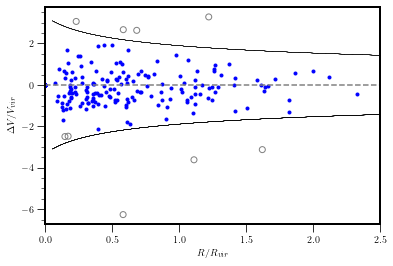

In [25]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    galaxies_out = galaxies[galaxies["outlier"] == True]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_clean["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                c = 'blue', marker = ".")
    plt.scatter(galaxies_out["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_out["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                marker = "o", facecolors = "none", edgecolors = "gray")
    plt.plot(r/Rvir, vesc/Vvir, c = "black", linestyle = "--", linewidth = 0.1)
    plt.plot(r/Rvir, -vesc/Vvir, c = "black", linewidth = 0.1)
plt.xlabel("$R/R_{vir}$")
plt.ylabel("$\Delta V/V_{vir}$")
plt.xlim((0,2.5))
#plt.ylim((-1550,1550))
#plt.yticks(np.arange(-3, 4)*500);

Text(0, 0.5, '$\\Delta v$ $(km/s)$')

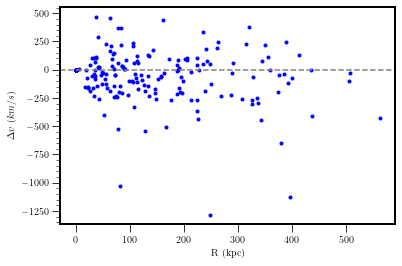

In [26]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"], galaxies_clean["vlos_to_gcenter"], c = 'blue', marker = ".")
plt.xlabel("R (kpc)")
plt.ylabel("$\Delta v$ $(km/s)$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

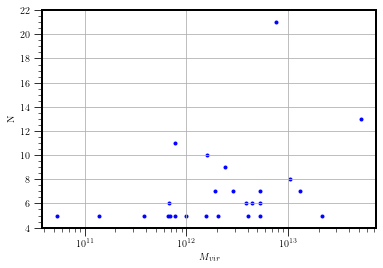

In [27]:
plt.scatter(G5["Mvir_sigma2"], G5["N_gal"], c = 'blue', marker = ".")
plt.xscale("log")
plt.xlabel("$M_{vir}$")
plt.ylabel("N")
plt.ylim((4, 22))
plt.grid()

# Absorptions

 **Look at the isolated galaxies** located at the foreground of QSO, by applying the same selection as Ilane or completely alone in the FOV...

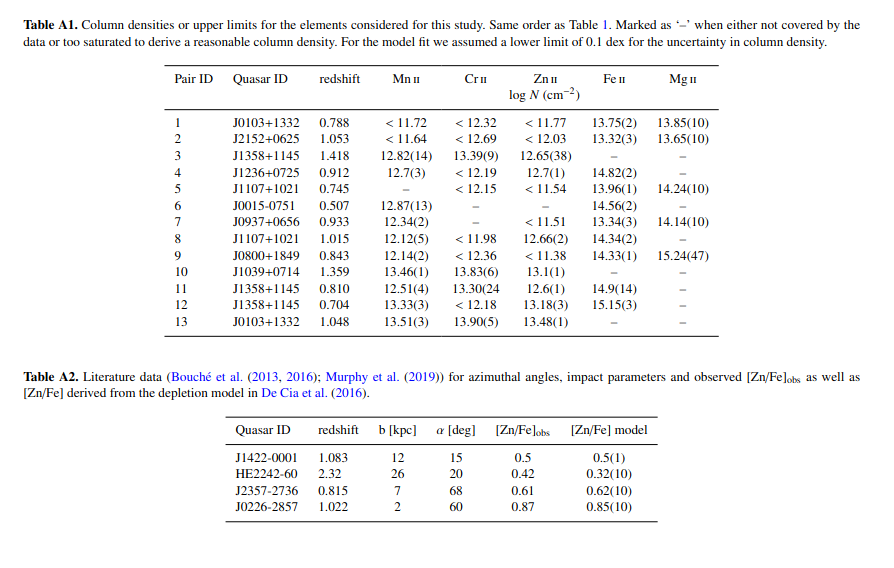

## Kinematics of the groups

In [28]:
#gid.plot_groups_2(R, G5, Nmin = 5, save = False,  filename = "none")

# Correlation with halo masses

Text(0.5, 0, '$M/M_{\\odot}$')

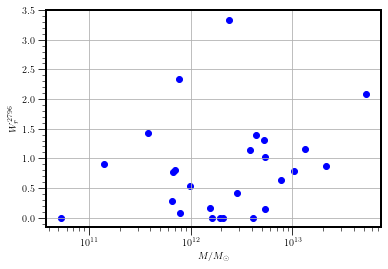

In [29]:
#plt.scatter(G3["Mvir_vel_disp"], G3["REW_2796"], marker = "o", c = "orange")
plt.scatter(G5["Mvir_sigma2"], G5["REW_2796"], marker = "o", c = "blue")
plt.xscale('log')
plt.grid()
plt.ylabel("$W^{2796}_r$")
plt.xlabel("$M/M_{\odot}$")

Text(0, 0.5, '$log(M/M_{\\odot})$')

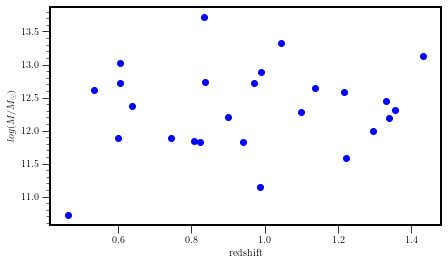

In [30]:
plt.figure(figsize = (7,4))
plt.scatter(G5["center_z"], np.log10(G5["Mvir_sigma2"]), color = "blue")
plt.xlabel("redshift")
plt.ylabel("$log(M/M_{\odot})$")

Text(0, 0.5, '$log(M*/M_{\\odot})$')

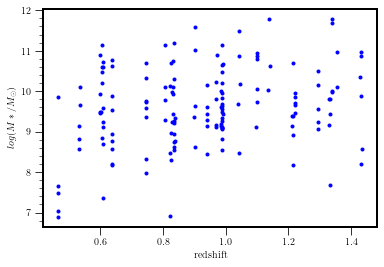

In [31]:
#plt.figure(figsize = (6,5))
#plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["Z"], galaxies_clean["mass"], c = 'blue', marker = ".")
plt.xlabel("redshift")
plt.ylabel("$log(M*/M_{\odot})$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

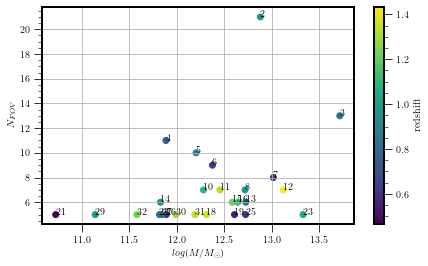

In [32]:
plt.figure(figsize = (7,4))
plt.scatter(np.log10(G5["Mvir_sigma2"]), G5["N_gal"], c = G5["center_z"])
plt.colorbar(label = "redshift")


X = np.array(np.log10(G5["Mvir_sigma2"]))
Y = np.array(G5["N_gal"],)
txt = np.array(G5["ID"])

for i in range(len(G5)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

plt.xlabel("$log(M/M_{\odot})$")
plt.ylabel("$N_{FOV}$")
plt.grid()

# Bmin or Bcenter ?

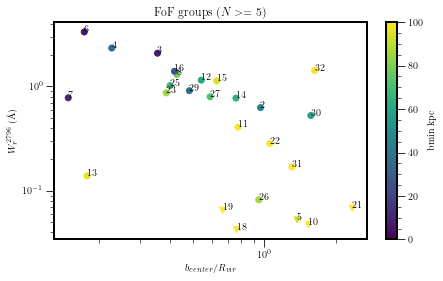

In [33]:
plt.figure(figsize = (7,4))
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

# Fit of the MgII decrease

In [34]:
from scipy.optimize import minimize
from scipy import integrate

The fit is performed using the method described in Hogg 2010 but also taking into accout the upper limit as in Dutta 2020 and Rubin 2018. The idea is to take into account the uncertainties along the 2 axis by taking the distance to the linear relation. 

First, when we look at the uncertainties we can see that there is a nan values:

In [35]:
G5[["b_min_kpc","b_center_kpc_norm2", "REW_2796", "sig_REW_2796"]]

,b_min_kpc,b_center_kpc_norm2,REW_2796,sig_REW_2796
1,46.37,0.963220,0.627,0.030
2,7.77,0.354076,2.085,0.016
3,36.59,0.226956,2.336,0.010
4,93.01,1.376444,0.000,0.000
5,6.06,0.173869,3.335,0.025
6,10.36,0.148748,0.779,0.037
7,79.59,0.427539,1.303,0.028
9,253.48,1.534437,0.000,0.000
10,113.48,0.773294,0.407,0.012
11,60.96,0.541460,1.150,NaN


In [36]:
idx = G5.index[G5["sig_REW_2796"].isnull()].to_list()
G5.loc[idx, "sig_REW_2796" ] = 0.05

we affect a value:

In [37]:
Abs = pd.read_csv("MgII_all_absorption")

The likelihood from Dutta is composed of 2 terms:

\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \int_{-\infty}^{W_i} \frac{dW'}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W' - W(R_i)}{\sigma_i}\right]^2\right)
\end{equation}

The first one is the classic one for points that have MgII detection. The second term is there to take into account the points that have an upper detection limit. To compute this second term we can use the erf function, defined as:

\begin{equation}
    erf(z) = \frac{2}{\pi}\int_0^{z} e^{-t^2}dt
\end{equation}

For that we Pose, for each subterm i: 
\begin{equation}
    x = \frac{W'-W(R_i)}{\sqrt{2}\sigma_i}
\end{equation}

hence we have:
\begin{equation}
    dx = \frac{dW'}{\sqrt{2}\sigma_i}
\end{equation}

And for $W' = Wi$ we have 
\begin{equation}
    x = \frac{W_i-W(R_i)}{\sqrt{2}\sigma_i}\equiv{}X
\end{equation}

In consequence:
\begin{equation}
    I = \frac{\sqrt{2}\sigma_i}{\sqrt{2\pi\sigma_i^2}}\int_{-\infty}^{X} e^{-x^2}dx
\end{equation}

So: 
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\int_{-\infty}^{0} e^{-x^2}dx + \int_{0}^{X} e^{-x^2}dx\right]
\end{equation}
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\frac{\sqrt{\pi}}{2}+ \frac{\sqrt{\pi}}{2} erf(X)\right]
\end{equation}
\begin{equation}
    I = \frac{1}{2}\left[1+ erf(X)\right]
\end{equation}


So Finally, the total likelihood is: 
\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \frac{1}{2}\left[1+ erf(X_i)\right]
\end{equation}



We also have to take into accout an intrisic scatter $\sigma_c$. For that we use the method described in Chen 2010. We first assume a value and then we iter to refine the intrisic scatter.
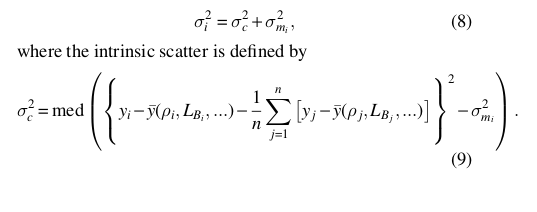

### for bcenter/Rvir

We define the input data:

In [406]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

the y-uncertainties for the point with no detection are not defined in the catalog but we must affect a value. When we look at the plots above we can see that the uncertainty increase when the REW decrease (which is logical). if we plot the uncertainty as a function of the REW (see below) we can assume that a value of ~ 0.3 is of the good order of magnitude.

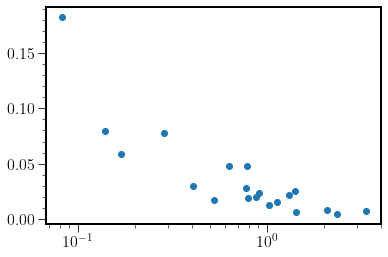

In [407]:
plt.scatter(G5_abs["REW_2796"], G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
plt.xscale("log")
#plt.yscale("log")

N =  0
1.1752345862382918
N =  1
0.5214406613453394
N =  2
0.5344953016375498
N =  3
0.5349694529519438
N =  4
0.5349860403633345


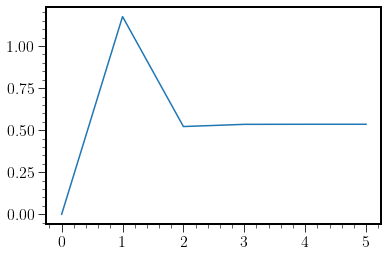

In [408]:
LMG, sig_intr_lst = gid.fit_REW(G5, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
                                Niter = 5, init_param = np.array([1.5,-4]))

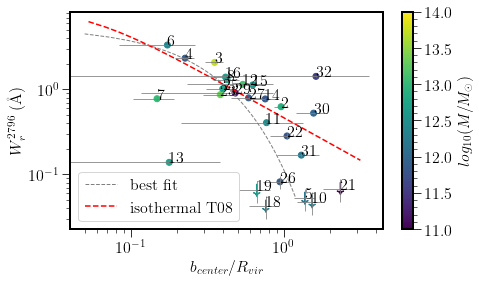

In [426]:
bbb = np.linspace(10, 600, 200)
www = gid.Tinker_2008(bbb)
rvir = gid.get_Rvir(1e12, 0.6)

plt.figure(figsize = (7,4))
X = np.linspace(0.05, 1.2, 50)
plt.plot(X, np.exp(gid.model(LMG['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
plt.plot(bbb/rvir, www, label = "isothermal T08", linestyle = "--", c = "r")
plt.legend()

plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "$log_{10}(M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = (np.ones(len(G5_noabs["sig_REW_2796"]))*0.3*G5_noabs["detection_limit"]),\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

The 0.1 A EW is reached for: 

## Now for the plot with bmin

In [43]:
x1 = np.array(G5_abs["b_min_kpc"])
x2 = np.array(G5_noabs["b_min_kpc"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.zeros(len(x1))
sig_x2 = np.zeros(len(x2))
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

N =  0
0.4689452458698493
N =  1
0.4235652421873078
N =  2
0.417288933050757
N =  3
0.4068586144700469
N =  4
0.4067643653690369
N =  5
0.40374619337848683
N =  6
0.4047451520536143
N =  7
0.4520543576868176
N =  8
0.41860004835921727
N =  9
0.40282749669028484


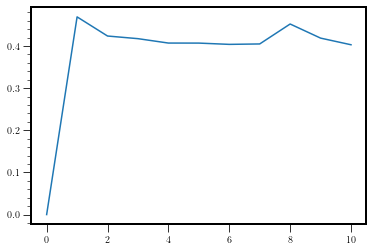

In [44]:
LMG, sig_intr_lst = gid.fit_REW(G5, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
                                Niter = 10, init_param = np.array([0,-0.015]))

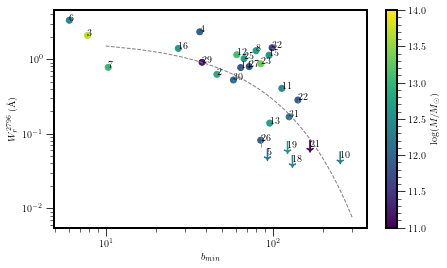

In [45]:
plt.figure(figsize = (7,4))
X = np.linspace(10, 300, 50)
plt.plot(X, np.exp(gid.model(LMG['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [46]:
LMG['x']

array([ 0.5935899 , -0.01829965])

In [47]:
LL_Hogg_total_bmin['x']

NameError: name 'LL_Hogg_total_bmin' is not defined

In [ ]:
LL_Hogg_total_bmin

# Normalized by the Rvir of the closest galaxy

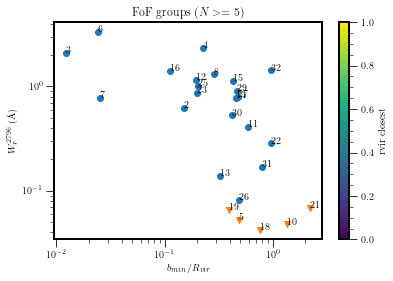

In [48]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5")
plt.scatter(G5_noabs["b_min_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5")
plt.colorbar(label = "rvir closest")

X = np.array(G5_abs["b_min_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

KeyError: 'Rvir_closest'

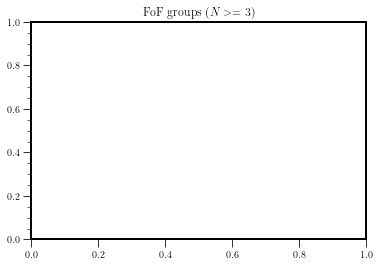

In [49]:
plt.title("FoF groups ($N >= 3$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c=G3_abs["Rvir_closest"], vmin = 10, vmax = 200)
plt.scatter(G3_noabs["b_min_kpc_norm2"], G3_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
           c=G3_noabs["Rvir_closest"], vmin = 10, vmax = 200)
plt.colorbar(label = "rvir closest")

X = np.array(G3_abs["b_min_kpc_norm2"])
Y = np.array(G3_abs["REW_2796"])
txt = np.array(G3_abs["ID"])

#for i in range(len(G3_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G3_noabs["b_min_kpc_norm2"])
Y = np.array(G3_noabs["detection_limit"])
txt = np.array(G3_noabs["ID"])

#for i in range(len(G3_noabs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}/R_{vir} closest$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.01, 5))

# Investigation other parameters

# Column density

In [51]:
G5_abs["NHI"], G5_abs["sigma_NHI"] = gid.Fukugita(G5_abs["REW_2796"], G5_abs["sig_REW_2796"], G5_abs["center_z"])
G5_abs["NHI_limit"], _ = gid.Fukugita(G5_abs["detection_limit"], 1, G5_abs["center_z"])
G5_noabs["NHI"], G5_noabs["sigma_NHI"] = gid.Fukugita(G5_noabs["REW_2796"], G5_noabs["sig_REW_2796"], G5_noabs["center_z"])
G5_noabs["NHI_limit"], G5_noabs["sigma_NHI"] = gid.Fukugita(G5_noabs["detection_limit"], \
                        0.2*G5_noabs["detection_limit"], G5_noabs["center_z"])

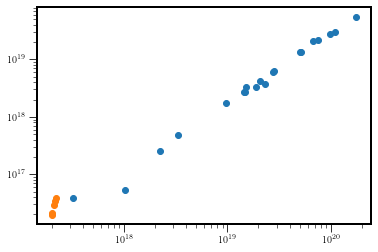

In [52]:
plt.scatter(G5_abs["NHI"], G5_abs["sigma_NHI"])
plt.scatter(G5_noabs["NHI_limit"], G5_noabs["sigma_NHI"])
plt.xscale("log")
plt.yscale("log")

In [53]:
G5_noabs["sigma_NHI"]

4     2.975192e+16
9     3.373966e+16
17    3.852419e+16
18    2.162482e+16
20    1.994972e+16
Name: sigma_NHI, dtype: float64

We cannot make a single plot with just 2 different y axis (1 for W2796 and 1 for NHI) because the NHI conversion depends on the redshift...

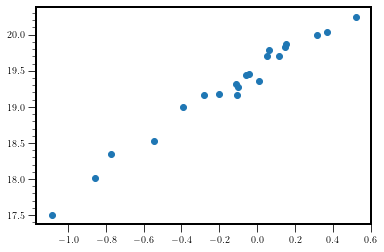

In [54]:
plt.scatter(np.log10(G5["REW_2796"]), np.log10(G5["NHI"]))

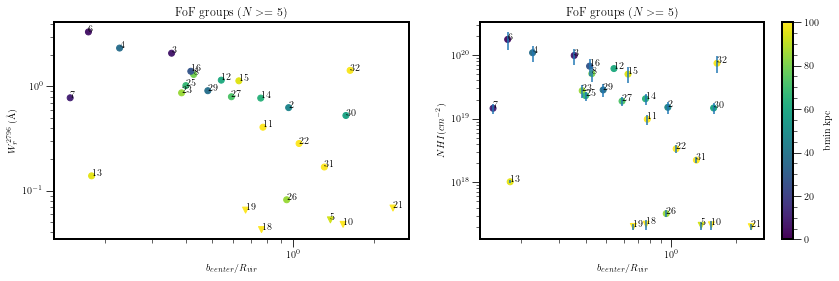

In [55]:
plt.figure(figsize = (14,4))
plt.subplot(121)
plt.title("FoF groups ($N >= 5$)")
##plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

plt.subplot(122)
plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"], yerr = G5_noabs["sigma_NHI"], fmt = 'none')
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"],\
            marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$NHI (cm^{-2})$")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

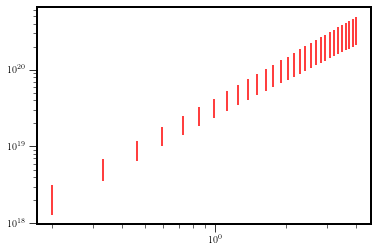

In [56]:
W = np.linspace(0.2, 4, 30)
N, sig = gid.Fukugita(W, 0.05, 1)
#plt.errorbar(G5_abs["REW_2796"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
#plt.scatter(G5_abs["REW_2796"], G5_abs["NHI"], c = G5_abs["center_z"])
plt.errorbar(W, N, yerr = sig, fmt = 'none', c = "r")
#plt.scatter(W, N)
#plt.colorbar()
plt.yscale("log")
plt.xscale("log")

# With DM profile

On the NHI vs b plot, we can add the standard NFW DM profile. But we must care about the fact that the NHI is a column density, ie a density integrated along the LOS. In order to compare things consistently, it is necessary to convert NFW density into a column density (a cut is necessary or it will diverge) or alternatively to convert the column density into a density (with a strong assumption of a spherical distribution of NHI?)...

In [57]:
from scipy import integrate

Text(0, 0.5, 'log10(rho)')

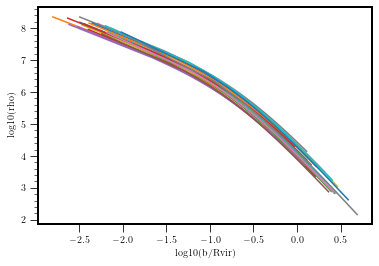

In [58]:
b = np.linspace(1, 400)
rho = gid.nfw_rho(b, 2e6, 30)
rvir = G5_abs["Mvir_sigma2"]
mvir = G5_abs["Mvir_sigma2"]

for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    plt.plot(np.log10(b/r), np.log10(rho))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

In [59]:
def nfw_rho_2(theta, b, rhoO, rs):
    K = b/np.cos(theta)/rs
    D = K*(1+K)**2
    rho = rho0*b/D/((np.cos(theta))**2)
    return rho

## Now with the equation from Bartelmann 1996:

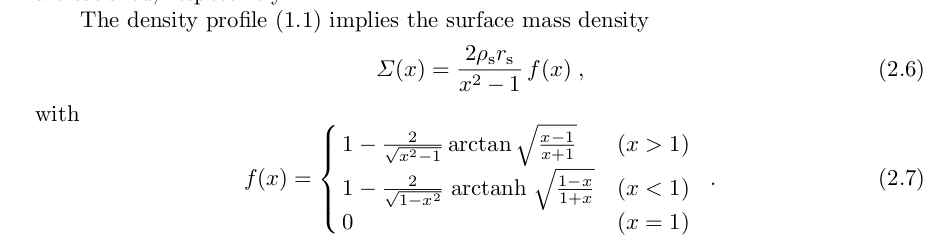

In [60]:
def calc_sigma_DM(r, rhos, rs):
    x = r/rs
    Sigma = 2* rhos*rs*ff(x)/(x**2-1)
    return Sigma

def ff(x):
    if x> 1: return (1-2*np.arctan(((x-1)/(x+1))**0.5)/((x**2-1)**0.5))
    elif x<1: return (1-2*np.arctanh(((1-x)/(x+1))**0.5)/((1-x**2)**0.5))
    elif x == 1: return 0
        

In [61]:
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
rvir

156.28710893311342

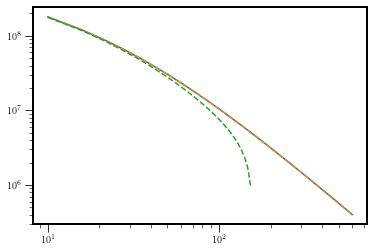

In [62]:
sig_dm = []
rho_column = []
rho_trunc = []
for bb in b:
    sig_dm.append(calc_sigma_DM(bb, rho0, rs))
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
sig_dm = np.array(sig_dm)
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

plt.loglog(b, sig_dm)
plt.loglog(b, rho_column, linestyle = "--")
plt.loglog(b, rho_trunc, linestyle = "--")

#### for a truncated NFW profile:

In [63]:
K= (1.66054e-27*u.kg/(u.cm**2)).to(u.kg/(u.kpc**2))
print(K)
K = K/const.M_sun
K

1.5810675746598502e+16 kg / kpc2


<Quantity 7.95141685e-15 1 / kpc2>

In [64]:
convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value
convert1

2.0883573729600368e-13

156.28710893311342 3346226.7715142868 28.545636311349668


(1e-10, 1e-06)

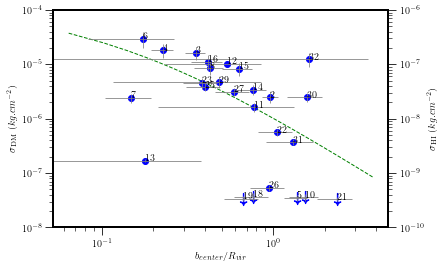

In [65]:

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

plt.plot(b/rvir, rho_column*convert1, linestyle = "--", color = "green", linewidth = 1)
#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G5_abs["NHI"]*u_to_kg
NHI_abs_sigma = G5_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G5_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G5_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G5_abs["b_center_kpc_norm2"], NHI_abs, xerr = G5_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G5_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G5_noabs["b_center_kpc_norm2_err"], yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, label = "groups N >= 5", \
             c = "blue")
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"]*u_to_kg)
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])*u_to_kg
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))

In [66]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(NHI_abs))
y2 = np.array(np.log(NHI_noabs))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(NHI_abs_sigma/NHI_abs)
sig_y2 = np.array(NHI_noabs_sigma/NHI_noabs)

In [67]:
G5_noabs["sigma_NHI"]

4     2.975192e+16
9     3.373966e+16
17    3.852419e+16
18    2.162482e+16
20    1.994972e+16
Name: sigma_NHI, dtype: float64

N =  0
2.62583841564491
N =  1
1.3854238810534498
N =  2
1.3194844679251683
N =  3
1.3127490203365546
N =  4
1.3120308446967193
N =  5
1.3119531404132083
N =  6
1.3119467362624189
N =  7
1.3119460626585697
N =  8
1.3119450900909995
N =  9
1.3119438537135242


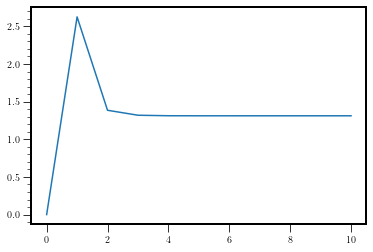

In [68]:
LMG, sig_intr_lst = gid.fit_REW(G5, x1, y1, sig_x1, sig_y1, x2, y2, sig_x2, sig_y2,\
                                Niter = 10, init_param = np.array([-15,-4]))

In [69]:
N = 5
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]

for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(NHI_abs_sigma/NHI_abs)
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([-15,-4]), method='BFGS')
    print(LL_model_Hogg_total['x'])
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

N =  0


NameError: name 'logL_Hogg_total' is not defined

In [70]:
LMG

      fun: 34.385427921925505
 hess_inv: array([[ 0.44651849, -0.5327238 ],
       [-0.5327238 ,  0.8523585 ]])
      jac: array([-1.43051147e-06,  2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([-13.67295049,  -7.19895697])

In [71]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_diemer22
from colossus.halo import profile_outer
from colossus.halo import profile_composite
from colossus.lss import bias
cosmo = cosmology.setCosmology('planck18')

In [72]:
np.log10(np.median(G5["Mvir_sigma2"]))

12.347188410255871

In [476]:
b = np.linspace(10, 10000, 500)
Mvir = 10**(12.35)
z = 1
bs = bias.haloBias(Mvir, z, 'vir')
rho_m = cosmo.rho_m(z)  #in M⊙h2/kpc3
h = cosmo.H0/100
#rho_nfw = p_nfw.density(r)
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
cvir = c = rvir/rs
kwargs = dict(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_mean = profile_composite.compositeProfile('nfw', outer_names = ['mean'], **kwargs)
p_cf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'cf'], bias = bs, **kwargs) 
p_inf = profile_composite.compositeProfile('nfw', outer_names = ['mean', 'infalling'], \
                                           pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
d22_mean = profile_composite.compositeProfile('diemer22', outer_names = ['mean'],**kwargs)
d22_inf = profile_composite.compositeProfile('diemer22', outer_names = ['mean', 'infalling'], \
                                              pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)
#d22_inf = profile_composite.compositeProfile('diemer22', outer_names = ['mean', 'infalling'], **kwargs)



In [474]:
len(b/rvir)

500

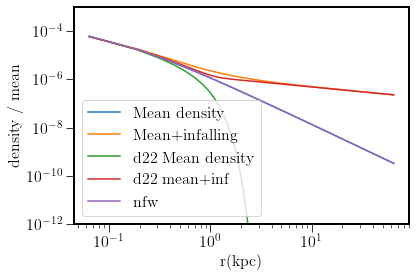

In [477]:
#r = 10**np.arange(0,5,0.02)
#r = r*h
surf_dens_nfw = p_nfw.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_nfw = surf_dens_nfw*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens = p_mean.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens = surf_dens*const.M_sun.value/(const.kpc.to(u.cm).value**2)
#surf_dens_cf = p_cf.surfaceDensity(b/h) #M⊙h/kpc2
#surf_dens_cf = surf_dens_cf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens_pinf = p_inf.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_pinf = surf_dens_pinf*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens_d22 = d22_mean.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_d22 = surf_dens_d22*const.M_sun.value/(const.kpc.to(u.cm).value**2)
surf_dens_d22_inf = d22_inf.surfaceDensity(b/h) #M⊙h/kpc2
surf_dens_d22_inf = surf_dens_d22_inf*const.M_sun.value/(const.kpc.to(u.cm).value**2)


plt.figure()
plt.loglog()
plt.xlabel('r(kpc)')
plt.ylabel('density / mean')
plt.plot(b/rvir, surf_dens, '-', label = 'Mean density');
#plt.plot(b/rvir, surf_dens_cf, '-', label = 'Mean+corrfunc');
plt.plot(b/rvir, surf_dens_pinf, '-', label = 'Mean+infalling');
plt.plot(b/rvir, surf_dens_d22, '-', label = 'd22 Mean density');
plt.plot(b/rvir, surf_dens_d22_inf, '-', label = 'd22 mean+inf');
plt.plot(b/rvir, surf_dens_nfw, '-', label = 'nfw');
plt.ylim(1e-12, 1e-3)
plt.legend();

156.28710893311342 3346226.7715142868 28.545636311349668


(0.07, 4)

<Figure size 504x288 with 0 Axes>

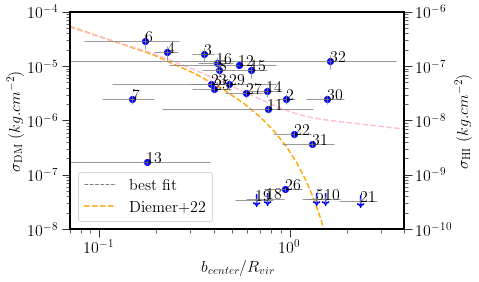

In [479]:
plt.figure(figsize = (7,4))

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
rho_trunc = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

#plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
#plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")

plt.plot(b/rvir, surf_dens_d22, '--', color = "orange", label = "Diemer+22");
plt.plot(b/rvir, surf_dens_d22_inf, '--', color = "pink", label = "Diemer+22");


#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G5_abs["NHI"]*u_to_kg
NHI_abs_sigma = G5_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G5_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G5_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G5_abs["b_center_kpc_norm2"], NHI_abs, xerr = G5_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G5_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G5_noabs["b_center_kpc_norm2_err"],\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, \
             c = "blue")


X = np.linspace(0.05, 1.4, 50)
ax2.plot(X, np.exp(gid.model(LMG['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")
ax2.plot([0], [0], '--', color = "orange", label = "Diemer+22");

plt.legend()
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"]*u_to_kg)
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])*u_to_kg
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))
plt.xlim((0.07, 4))

1 1
2 2
3 3
4 4
5 5
6 6
7 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
17 15
18 16
20 17
21 18
22 19
24 20
25 21
26 22
28 23
29 24
30 25
31 26


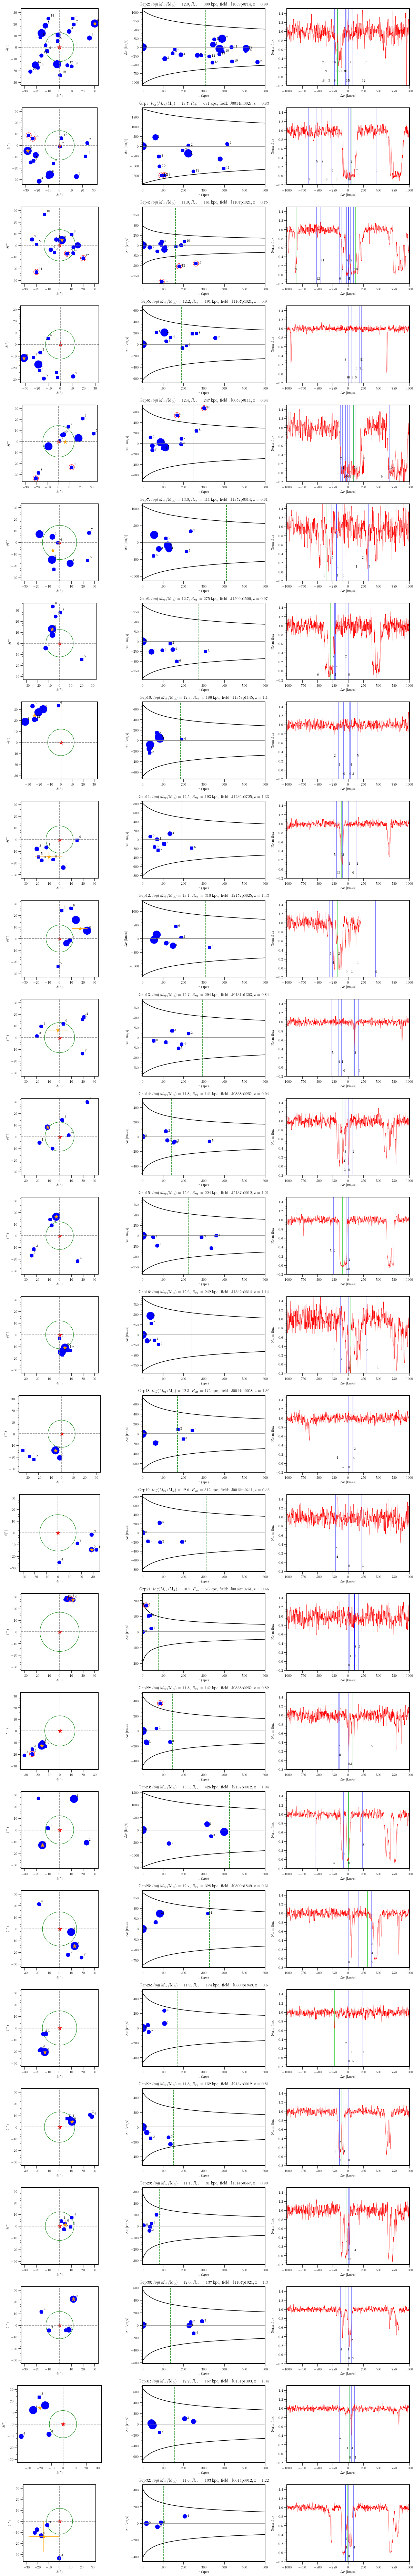

In [77]:
gid.plot_groups_2(R,G5, save = False)

# Passive galaxies

TO compute the SFR we can use the relations from Gilbank 2010, 2011: 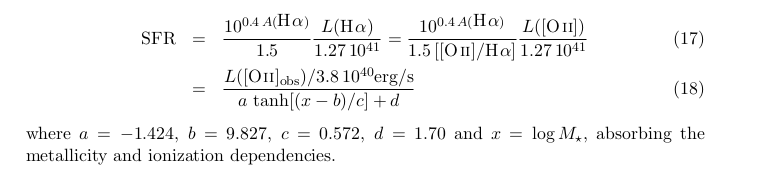

In [78]:
def get_SFR(logMstar, LOII):
    a = -1.424
    b = 9.827
    c = 0.572
    d = 1.7
    lnorm = 3.8e40
    SFR = LOII/lnorm/(a*np.tanh((logMstar-b)/c)+d)
    return SFR

In [79]:
R["OII_FLUX"] = (R["OII3729_FLUX"] + R["OII3726_FLUX"])*1e38

In [80]:
R["SFR_from_OII"] = get_SFR(R["sed_logMass"], R["OII_FLUX"])

(-2.0, 3.0)

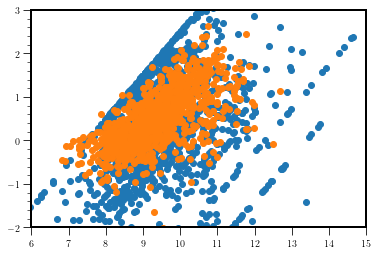

In [81]:
plt.scatter(R["sed_logMass"], np.log10(R["sed_curr_sfr"]))
plt.scatter(R["sed_logMass"], np.log10(R["SFR_from_OII"]))
#plt.xscale("log")
#plt.yscale("log")
plt.xlim((6, 15))
plt.ylim((-2, 3))

(-3.0, 3.0)

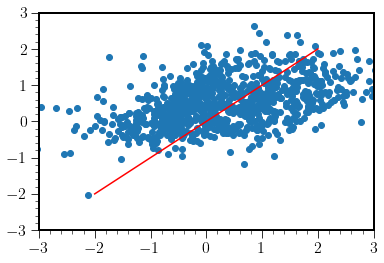

In [404]:
plt.scatter(np.log10(R["sed_curr_sfr"]), np.log10(R["SFR_from_OII"]))
plt.plot([-2, 2], [-2, 2], c = "r")
plt.ylim((-3, 3))
plt.xlim((-3, 3))

In [83]:
R

,ID,field_id,DATASET,FROM,Z,ZCONF,is_QSO,is_star,DR1_id,DR1_nbmatch,...,lambda_mgii_b,REW_2796,sig_REW_2796,z_absorption,z_absorption_dist,vel_absorption_dist,bool_absorption,QSO_is_behind,OII_FLUX,SFR_from_OII
0,11001,J0014m0028,b'beta',b'FELINE',1.92000,3,1,0,NaN,NaN,...,8186.307600,0.0,0.0,0.0,0,0.0,0,False,NaN,NaN
1,32081,J2152p0625,b'psfsub',b'FELINE',0.87357,3,0,0,NaN,NaN,...,5252.609702,0.0,0.0,0.0,0,0.0,0,True,5.250172e+41,8.220842
2,32076,J2152p0625,b'psfsub',b'FELINE',1.01279,2,0,0,NaN,NaN,...,5642.917149,0.0,0.0,0.0,0,0.0,0,True,3.092236e+40,NaN
3,32080,J2152p0625,b'psfsub',b'FELINE',1.01400,3,0,0,NaN,NaN,...,5646.309420,0.0,0.0,0.0,0,0.0,0,True,1.737688e+42,33.080249
4,32051,J2152p0625,b'psfsub',b'FELINE',1.01310,3,0,0,NaN,NaN,...,5643.786243,0.0,0.0,0.0,0,0.0,0,True,3.712510e+41,4.367386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,11137,J0014m0028,b'psfsub',b'FELINE',1.39793,3,0,0,NaN,NaN,...,6722.668693,0.0,0.0,0.0,0,0.0,0,True,6.446056e+41,13.444913
2016,11179,J0014m0028,b'psfsub',b'FELINE',1.39893,2,0,0,NaN,NaN,...,6725.472223,0.0,0.0,0.0,0,0.0,0,True,4.741357e+40,NaN
2017,11142,J0014m0028,b'psfsub',b'FELINE',1.39643,3,0,0,NaN,NaN,...,6718.463398,0.0,0.0,0.0,0,0.0,0,True,1.487325e+41,1.810311
2018,11155,J0014m0028,b'psfsub',b'FELINE',1.39900,2,0,0,NaN,NaN,...,6725.668470,0.0,0.0,0.0,0,0.0,0,True,1.790004e+41,2.303534


In [84]:
for c in R.columns:
    print(c)

ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
white_ID
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_i
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
mass_noNA
mass
dist_ang
dist_lum
N100_neighb
N50_neighb
group_id
DMEAN
D12
V12
is_grouped
Mvir_sigma2
Mvir_sigma3
Rvir_sigma2
Rvir_sigma3
mass10
ra_mass
dec_mass
z_mass
Mvir

# Group metallicity

We can use Zn/Fe in the UVES spectra to investigate groups metallicity.

We can look in Martin 2021 if some groups correspond to his sample: 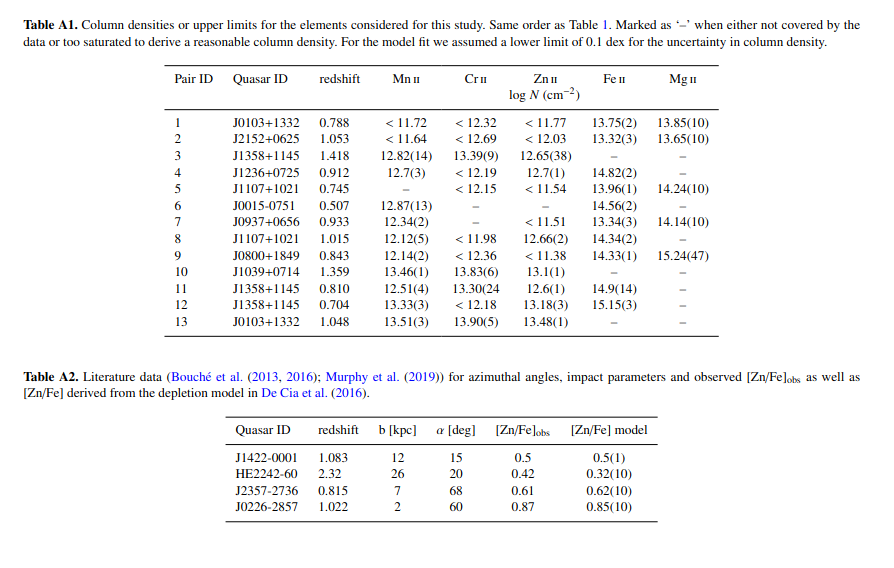

# Absorber kinematics

In [85]:
fff = "J1039p0714"
"j"+fff[1:]

'j1039p0714'

In [290]:
grplist = G5["group_id"]
Abs = pd.read_csv("MgII_all_absorption")

In [87]:
#for i in range(len(G5)):
#    gid.plot_group_absorption2(i, R, G5, Abs)

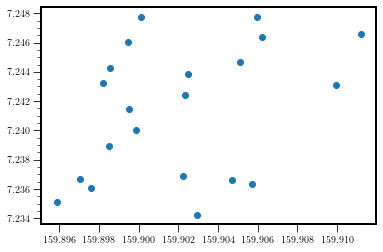

In [88]:
KK = G5.head(1)
KK = KK.squeeze()
RR = R[R["group_id"] == KK["group_id"]]
plt.scatter(RR["RA"]*u.degree, RR["DEC"]*u.degree)


In [89]:
#gid.plot_groups_2(R, G5_raw, Nmin = 5, save = True, filename="catalog_article")

# Comparison with isolated galaxies

In [90]:
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelleft']=True
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.major.size']=8
plt.rcParams['ytick.left']= True
plt.rcParams['ytick.major.left']= True

In [91]:
R = gid.get_Nxxx_neighb(R, radius = 2000)

In [92]:
Mhalo_lst = []
Rvir_lst = []
for i, kk in R.iterrows():
    mm = gid.Behroozi(kk["mass"], kk["Z"])
    Mhalo_lst.append(mm)
    #print(kk["mass"], mm, kk["Z"])
R["Mvir"] = Mhalo_lst

for i, kk in R.iterrows():
    try:
        rr = gid.get_Rvir(10**kk["Mvir"], kk["Z"])
        Rvir_lst.append(rr)
    except:
        Rvir_lst.append(3000)
    #print(kk["mass"], rr, kk["Z"])
R["Rvir"] = Rvir_lst

(6.0, 13.0)

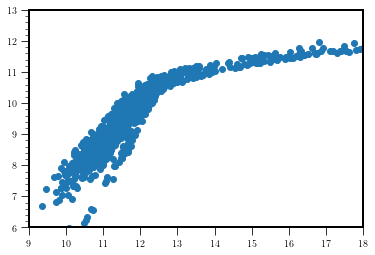

In [93]:
plt.scatter(R["Mvir"], R["mass"])
plt.xlim((9, 18))
plt.ylim((6, 13))

In [94]:
f24 = R["N2000_neighb"] == 0
f25 = R["Z"]< R["zqso_sdss_x"] - 1e6*(1+R["zqso_sdss_x"])/const.c

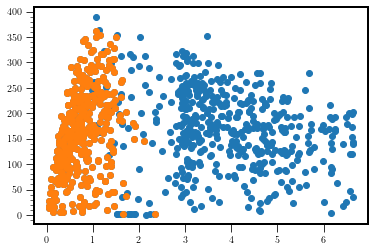

In [95]:
K1 = R[f24]
K2 = R[f24 & f25]
K2_abs = R[f24 & f25 & f22]
K2_noabs = R[f24 & f25 & f21]
 
plt.scatter(K1["Z"], K1["B_KPC"])
plt.scatter(K2["Z"], K2["B_KPC"])

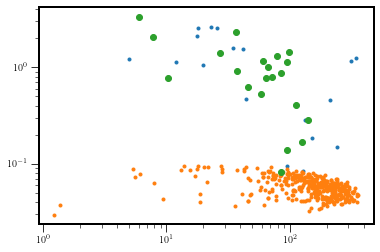

In [96]:
plt.scatter(K2_abs["B_KPC"], K2_abs["REW_2796"], marker = ".")
plt.scatter(K2_noabs["B_KPC"], K2_noabs["detection_limit"], marker = ".")
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"])
plt.xscale("log")
plt.yscale("log")

(0.01, 5)

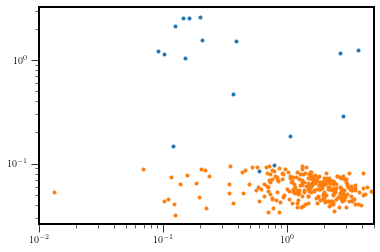

In [97]:
plt.scatter(K2_abs["B_KPC"]/K2_abs["Rvir"], K2_abs["REW_2796"], marker = ".")
plt.scatter(K2_noabs["B_KPC"]/K2_noabs["Rvir"], K2_noabs["detection_limit"], marker = ".")
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"])
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.01, 5))

(array([  4.,  56., 184.,  38.,   3.,   4.,   1.,   0.,   0.,   1.]),
 array([0.9367898 , 0.9814659 , 1.026142  , 1.0708181 , 1.11549419,
        1.16017029, 1.20484639, 1.24952249, 1.29419859, 1.33887469,
        1.38355079]),
 <BarContainer object of 10 artists>)

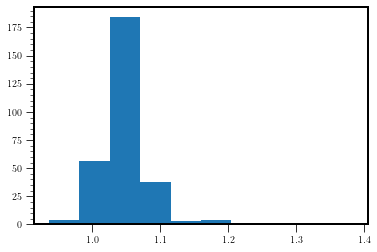

In [98]:
plt.hist(np.log10(K2["Mvir"]))

In [99]:
len(K2[np.isnan(K2["mass"])])

101

In [100]:
len(K2)

402

In [101]:
len(R[np.isnan(R["mass"])])

664

In [102]:
for c in R.columns:
    print(c)

ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
white_ID
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_i
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
mass_noNA
mass
dist_ang
dist_lum
N100_neighb
N50_neighb
group_id
DMEAN
D12
V12
is_grouped
Mvir_sigma2
Mvir_sigma3
Rvir_sigma2
Rvir_sigma3
mass10
ra_mass
dec_mass
z_mass
Mvir

# Strong absorbers

In [372]:
Abs = pd.read_csv("MgII_all_absorption")

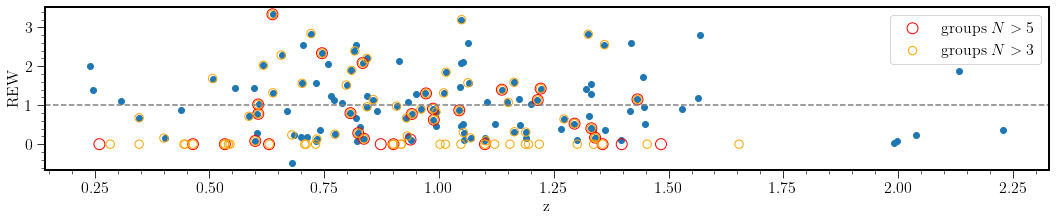

In [391]:
plt.figure(figsize = (18,3))
plt.scatter(Abs["z_abs"], Abs["REW_2796"])
plt.scatter(G5_raw["center_z"], G5_raw["REW_2796"], marker = "o", s = 120, facecolors = "none", edgecolors ="r",\
           label = "groups $N>5$")
plt.scatter(G3["center_z"], G3["REW_2796"], marker = "o", s = 70, facecolors = "none", edgecolors ="orange",
           label = "groups $N>3$")
plt.axhline(1, color = "gray", linestyle = "--")
plt.xlabel("z")
plt.ylabel("REW")
plt.legend()

In [374]:
Abs = gid.get_Nxxx_abs(Abs, R, bmax = 2000, dv = 0.5e6)
Abs2 = gid.get_Nxxx_abs(Abs, R, bmax = 2000, dv = 1e6)

In [375]:
Abs_05A = Abs[Abs["REW_2796"]>=0.5]
Abs_1A = Abs[Abs["REW_2796"]>=1]
Abs_15A = Abs[Abs["REW_2796"]>=1.5]
Abs_2A = Abs[Abs["REW_2796"]>=2]
Abs_3A = Abs[Abs["REW_2796"]>=3]

Abs_b05A = Abs[Abs["REW_2796"]<0.5]
Abs_in1A = Abs[(Abs["REW_2796"]>=0.5) &  (Abs["REW_2796"]< 1.5)]
Abs_in15A = Abs[Abs["REW_2796"]>=1.5]
Abs_in2A = Abs[(Abs["REW_2796"]>=1.5) &  (Abs["REW_2796"]< 2.5)]
Abs_in3A = Abs[(Abs["REW_2796"]>=2.5)]

G5_1A = G5_raw[G5_raw["REW_2796"]>=1]
G5_2A = G5_raw[G5_raw["REW_2796"]>=2]
G5_3A = G5_raw[G5_raw["REW_2796"]>=3]
G3_1A = G3[G3["REW_2796"]>=3]

print("total number of absorbers = ", len(Abs))
print("number of absorbers with REW above 1A = ", len(Abs_1A))
print("number of absorbers with REW above 2A = ", len(Abs_2A))
print("number of absorbers with REW above 3A = ", len(Abs_3A))
           
print("number of groups of 5 with REW above 1A = ", len(G5_1A))
print("number of groups of 5 with REW above 2A = ", len(G5_2A))
print("number of groups of 5 with REW above 3A = ", len(G5_3A))
print("number of groups of 3 with REW above 1A = ", len(G3_1A))

total number of absorbers =  126
number of absorbers with REW above 1A =  59
number of absorbers with REW above 2A =  21
number of absorbers with REW above 3A =  2
number of groups of 5 with REW above 1A =  9
number of groups of 5 with REW above 2A =  3
number of groups of 5 with REW above 3A =  1
number of groups of 3 with REW above 1A =  2


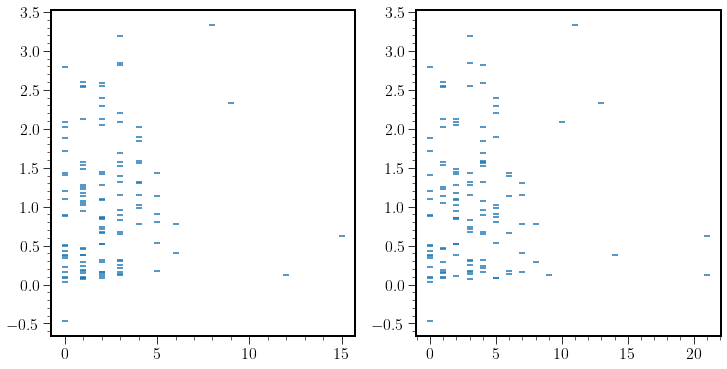

In [376]:
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.scatter(Abs1["N2000_abs"], Abs1["REW_2796"], marker = "_")
#plt.scatter(Abs3["N2000_abs"], Abs3["REW_2796"])
plt.subplot(122)
plt.scatter(Abs3["N2000_abs"], Abs3["REW_2796"], marker = "_")

Text(0.5, 0, 'N / abs')

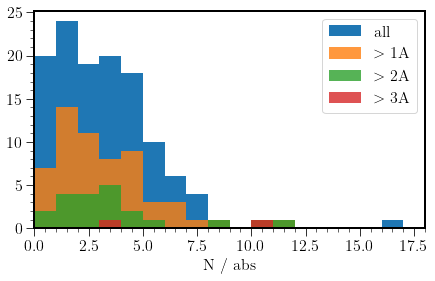

In [377]:
plt.figure(figsize =(7,4))
plt.hist(Abs["N2000_abs"], range = (0,20), bins = 20, label = "all")
#plt.hist(Abs_05A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_1A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.8, label = "$>$ 1A")
#plt.hist(Abs_15A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_2A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.8, label = "$>$ 2A")
plt.hist(Abs_3A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.8, label = "$>$ 3A")
plt.xlim((0,18))
plt.legend()
plt.xlabel("N / abs")

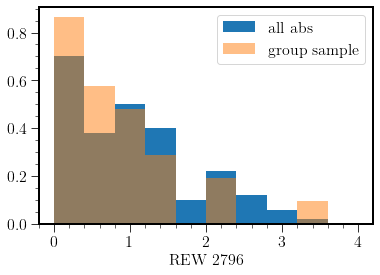

In [378]:
plt.hist(Abs["REW_2796"], density = True, range = (0,4), label = "all abs")
plt.hist(G5["REW_2796"], density = True, range = (0,4), alpha = 0.5, label = "group sample")
plt.xlabel("REW 2796")
plt.legend()

(0.0, 21.0)

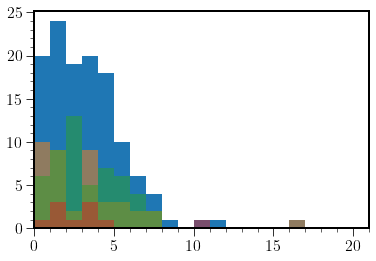

In [379]:
plt.hist(Abs["N2000_abs"], range = (0,20), bins = 20)
plt.hist(Abs_b05A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_in1A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
#plt.hist(Abs_15A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
#plt.hist(Abs_in2A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.hist(Abs_in3A["N2000_abs"], range = (0,20), bins = 20, alpha = 0.5)
plt.xlim((0,21))

Text(0, 0.5, 'REW')

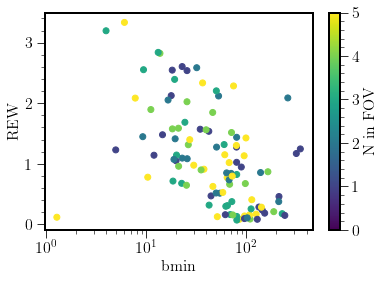

In [389]:
plt.scatter(Abs["bmin2000_abs"], Abs["REW_2796"], c = Abs["N2000_abs"], vmin = 0, vmax = 5)
plt.colorbar(label = "N in FOV")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("bmin")
plt.ylabel("REW")

In [395]:
G5_massive = G5_raw[G5_raw["Mvir_sigma2"]>1e13]
len(G5_massive)

5

In [396]:
G5_massive[["Mvir_sigma2", "REW_2796"]]

,Mvir_sigma2,REW_2796
0,1.542607e+13,0.118
2,5.236328e+13,2.085
6,1.045701e+13,0.779
11,1.322800e+13,1.150
22,2.146685e+13,0.869


# Covering fraction

In [103]:
folder = "run_17"

In [104]:
G5_bmin_lin = G5[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bcenter_lin = G5[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bmin_norm_lin = G5[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bcenter_norm_lin = G5[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bmin_lin = G5_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bcenter_lin = G5_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bmin_norm_lin = G5_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bcenter_norm_lin = G5_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G5_bmin_log = G5_bmin_lin.copy()
G5_bcenter_log = G5_bcenter_lin.copy()
G5_bmin_norm_log = G5_bmin_norm_lin.copy()
G5_bcenter_norm_log = G5_bcenter_norm_lin.copy()
G5_bmin_log["log10(b)"] = np.log10(G5_bmin_lin["b"])
G5_bcenter_log["log10(b)"] = np.log10(G5_bcenter_lin["b"])
G5_bmin_norm_log["log10(b)"] = np.log10(G5_bmin_norm_lin["b"])
G5_bcenter_norm_log["log10(b)"] = np.log10(G5_bcenter_norm_lin["b"])
G5_bmin_norm_lin["log10(b)"] = G5_bmin_norm_lin["b"]
G5_bcenter_norm_lin["log10(b)"] = G5_bcenter_norm_lin["b"]

In [105]:
G3_bmin_lin = G3[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bcenter_lin = G3[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bmin_norm_lin = G3[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bcenter_norm_lin = G3[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bmin_lin = G3_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bcenter_lin = G3_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bmin_norm_lin = G3_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bcenter_norm_lin = G3_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G3_bmin_log = G3_bmin_lin.copy()
G3_bcenter_log = G3_bcenter_lin.copy()
G3_bmin_norm_log = G3_bmin_norm_lin.copy()
G3_bcenter_norm_log = G3_bcenter_norm_lin.copy()
G3_bmin_log["log10(b)"] = np.log10(G3_bmin_lin["b"])
G3_bcenter_log["log10(b)"] = np.log10(G3_bcenter_lin["b"])
G3_bmin_norm_log["log10(b)"] = np.log10(G3_bmin_norm_lin["b"])
G3_bcenter_norm_log["log10(b)"] = np.log10(G3_bcenter_norm_lin["b"])
G3_bmin_norm_lin["log10(b)"] = G3_bmin_norm_lin["b"]
G3_bcenter_norm_lin["log10(b)"] = G3_bcenter_norm_lin["b"]

In [106]:
G5_bmin_lin.to_csv(folder + "/G5_mgii_bmin_lin.csv", index = False)
G5_bcenter_lin.to_csv(folder + "/G5_mgii_bcenter_lin.csv", index = False)
G5_bmin_log.to_csv(folder + "/G5_mgii_bmin_log.csv", index = False)
G5_bcenter_log.to_csv(folder + "/G5_mgii_bcenter_log.csv", index = False)
G5_bmin_norm_lin.to_csv(folder + "/G5_mgii_bmin_norm_lin.csv", index = False)
G5_bcenter_norm_lin.to_csv(folder + "/G5_mgii_bcenter_norm_lin.csv", index = False)
G5_bmin_norm_log.to_csv(folder + "/G5_mgii_bmin_norm_log.csv", index = False)
G5_bcenter_norm_log.to_csv(folder + "/G5_mgii_bcenter_norm_log.csv", index = False)

In [107]:
G3_bmin_lin.to_csv(folder + "/G3_mgii_bmin_lin.csv", index = False)
G3_bcenter_lin.to_csv(folder + "/G3_mgii_bcenter_lin.csv", index = False)
G3_bmin_log.to_csv(folder + "/G3_mgii_bmin_log.csv", index = False)
G3_bcenter_log.to_csv(folder + "/G3_mgii_bcenter_log.csv", index = False)
G3_bmin_norm_lin.to_csv(folder + "/G3_mgii_bmin_norm_lin.csv", index = False)
G3_bcenter_norm_lin.to_csv(folder + "/G3_mgii_bcenter_norm_lin.csv", index = False)
G3_bmin_norm_log.to_csv(folder + "/G3_mgii_bmin_norm_log.csv", index = False)
G3_bcenter_norm_log.to_csv(folder + "/G3_mgii_bcenter_norm_log.csv", index = False)

### fc for N>=5

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:07<00:00, 1247.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.633195 -11.740743 -8.546351 -5.395299 -2.879603 -1.120131
beta   2.192677   1.867241  2.038445  2.169613  2.385302  2.735316
f_out  0.178556   0.004230  0.037818  0.147223  0.340619  0.470308
p_out  0.610900   0.053539  0.286754  0.659421  0.900872  0.982991
alpha -5.4 [-11.74--1.12] (95\%) 
beta 2.2 [1.87-2.73] (95\%) 
f_out 0.1 [0.00-0.47] (95\%) 
p_out 0.7 [0.05-0.98] (95\%) 

WAIC 23.12 +/- 4.20 peff 1.19
WAIC deviance 20.732084288743533
LOO 23.14 +/- 4.21 peff 1.21
WBIC  31.820959508602613
Deviance Lmax 32.0067
DIC Lmax 41.9045 4.95
Deviance best 32.0833
DIC best 41.8278 4.87
|               WAIC |                LOO |               WBIC |               DIC |
| 23.118817703882275 | 23.143137298939457 | 31.820959508602613 | 41.82784964797099 |
['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.633195 -11.740743 

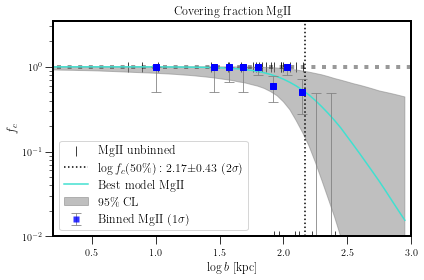

In [108]:
fc_G5_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bmin_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [109]:
-11.97 +5.6

-6.370000000000001

In [110]:
-1.3 +5.6

4.3

In [111]:
1.85 - 2.1

-0.25

In [112]:
2.67 - 2.1

0.5699999999999998

In [113]:
0.47 - 0.2

0.26999999999999996

In [114]:
0.05 - 0.6

-0.5499999999999999

MgII_closest_only_redshiftRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, zalpha, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:14<00:00, 618.43draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6360436966527225, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7064818094794825, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta', 'zalpha', 'f_out', 'p_out']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -4.817950 -11.519486 -8.199543 -4.849372 -1.736641   3.365500
beta    1.470881   0.272089  0.877935  1.479819  2.037062   2.676805
zalpha  3.109972 -10.758839  0.704379  2.888924  6.148545  14.115451
f_out   0.188900   0.007090  0.044691  0.165686  0.346662   0.472520
p_out   0.568432   0.048056  0.248589  0.595612  0.873819   0.982892
alpha -4.9 [-11.52-3.36] (95\%) 
beta 1.5 [0.27-2.68] (95\%) 
zalpha 2.9 [-10.76-14.12] (95\%) 
f_out 0.2 [0.01-0.47] (95\%) 
p_out 0.6 [0.05-0.98] (95\%) 

WAIC 23.67 +/- 4.74 peff 2.07
WAIC deviance 19.518397698429197
LOO 23.74 +/- 4.77 peff 2.11
WBIC  32.15483642049282
Deviance Lmax 30.7490
DIC Lmax 45.7189 7.48
Deviance best 31.5009
DIC best 44.9670 6.73
|               WAIC |                LOO |              WBIC |               DIC |
| 23.667276232698097 | 23.735494081593764 | 32.15483642049282 | 44.96698547983559 |
['alpha', '

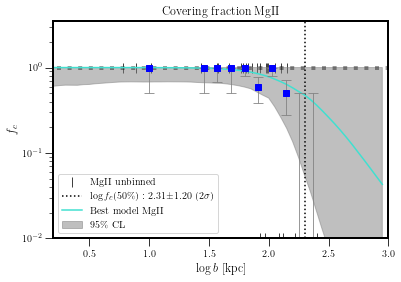

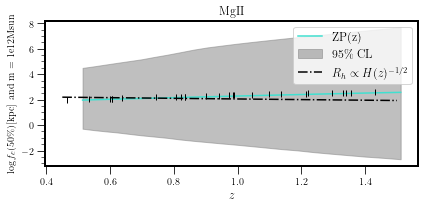

In [115]:
fc_G5_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bmin_log.csv", redshift = True, with_outliers = 'Robust_LR')

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:07<00:00, 1164.77draws/s]
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -3.901455 -10.670243 -7.206242 -4.125351 -1.407109  6.409545
beta   2.316295   0.536024  2.198201  2.431767  2.692686  2.932633
f_out  0.229226   0.008188  0.061915  0.219064  0.403413  0.484555
p_out  0.599761   0.052647  0.277551  0.641613  0.897613  0.985058
alpha -4.1 [-10.67-6.37] (95\%) 
beta 2.4 [0.54-2.93] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.05-0.99] (95\%) 

WAIC 27.37 +/- 4.48 peff 1.31
WAIC deviance 24.739377401116133
LOO 27.39 +/- 4.49 peff 1.33
WBIC  32.97387742567789
Deviance Lmax 36.1496
DIC Lmax 46.8487 5.35
Deviance best 36.2865
DIC best 46.7119 5.21
|               WAIC |                LOO |              WBIC |               DIC |
| 27.369231664914196 | 27.390772139290178 | 32.97387742567789 | 46.71190202420409 |
['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -3.901455 -10.670243 -7.2

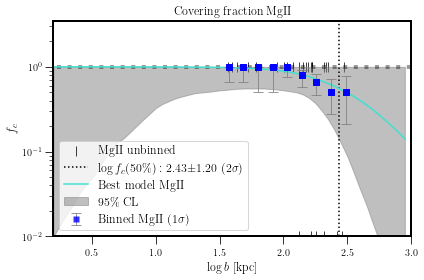

In [116]:
fc_G5_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_log.csv", redshift = False, with_outliers = 'Robust_LR')

MgII_closest_only_redshiftRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, zalpha, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:15<00:00, 578.95draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta', 'zalpha', 'f_out', 'p_out']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -3.727382 -12.026878 -7.814559 -4.011332 -0.280541   7.156648
beta    1.498593   0.231411  0.830632  1.501660  2.162375   2.784152
zalpha  3.201136 -13.310300 -0.047682  3.975648  7.834247  13.706835
f_out   0.228852   0.015306  0.082251  0.218382  0.385041   0.480668
p_out   0.495726   0.031720  0.185144  0.496385  0.803772   0.964019
alpha -4.0 [-12.03-7.12] (95\%) 
beta 1.5 [0.23-2.78] (95\%) 
zalpha 4.0 [-13.31-13.70] (95\%) 
f_out 0.2 [0.02-0.48] (95\%) 
p_out 0.5 [0.03-0.96] (95\%) 

WAIC 26.60 +/- 5.65 peff 2.27
WAIC deviance 22.048674289231087
LOO 26.69 +/- 5.71 peff 2.32
WBIC  32.78569052837799
Deviance Lmax 32.6752
DIC Lmax 48.7897 8.06
Deviance best 33.6999
DIC best 47.7651 7.03
|               WAIC |               LOO |              WBIC |               DIC |
| 26.596426230201946 | 26.68817752220413 | 32.78569052837799 | 47.76510231571045 |
['alpha', 'be

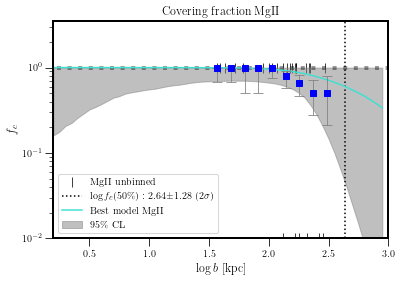

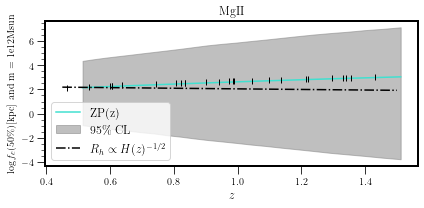

In [117]:
fc_G5_bcenter_z = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_log.csv", redshift = True, with_outliers = 'Robust_LR')

MgII_closest_only
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2495.78draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.008318 -4.281132 -2.968803 -1.867181 -1.040811 -0.558730
beta   1.685961  1.073783  1.286752  1.600939  2.116110  2.722461
alpha -1.9 [-4.28--0.56] (95\%) 
beta 1.6 [1.07-2.72] (95\%) 

WAIC 25.85 +/- 5.96 peff 1.63
WAIC deviance 22.593775826697907
LOO 25.91 +/- 5.98 peff 1.66
WBIC  28.972384700552727
Deviance Lmax 25.0132
DIC Lmax 29.4384 2.21
Deviance best 25.0407
DIC best 29.4109 2.19
|               WAIC |                LOO |               WBIC |                DIC |
| 25.849730108271483 | 25.914017107574796 | 28.972384700552727 | 29.410905604488512 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.008318 -4.281132 -2.968803 -1.867181 -1.040811 -0.558730
beta   1.685961  1.073783  1.286752  1.600939  2.116110  2.722461


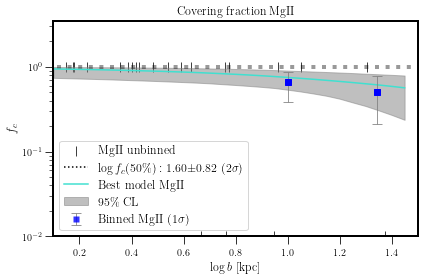

In [118]:
fc_G5_bcenter_norm_raw = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, xlim = [0.1, 1.5])

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:06<00:00, 1342.87draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.314791 -9.407344 -5.360977 -2.704036 -1.377956 -0.624895
beta   1.714380  0.851129  1.245537  1.666078  2.225845  2.783148
f_out  0.231131  0.012751  0.073004  0.223314  0.391926  0.480799
p_out  0.549418  0.047769  0.235933  0.563345  0.859892  0.979568
alpha -2.7 [-9.41--0.63] (95\%) 
beta 1.7 [0.85-2.78] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.05-0.98] (95\%) 

WAIC 26.72 +/- 5.42 peff 1.60
WAIC deviance 23.5113830655923
LOO 26.76 +/- 5.43 peff 1.62
WBIC  32.20266667848634
Deviance Lmax 33.4700
DIC Lmax 43.3691 4.95
Deviance best 33.7182
DIC best 43.1209 4.70
|              WAIC |                LOO |              WBIC |               DIC |
| 26.71768379197073 | 26.756747254513897 | 32.20266667848634 | 43.12089561209031 |
['alpha', 'beta', 'f_out', 'p_out']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.314791 -9.407344 -5.360977 -2.70

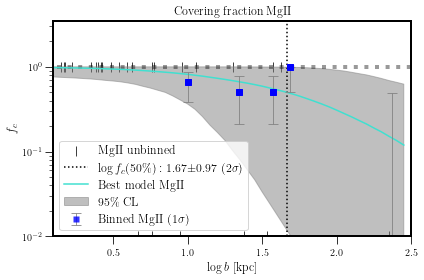

In [119]:
fc_G5_bcenter_norm = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, with_outliers = 'Robust_LR', xlim = [0.1, 2.5])

In [120]:
9.54 - 2.4

7.139999999999999

In [121]:
9.54 - 2.4

7.139999999999999

In [122]:
1.5 - 0.67

0.83

In [123]:
2.79 - 1.5

1.29

In [124]:
0.02 - 0.3

-0.27999999999999997

In [125]:
0.49 - 0.3

0.19

In [126]:
0.06 - 0.6

-0.54

In [127]:
0.98 - 0.6

0.38

### fc for N>=3

In [ ]:
#fc_G3_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bmin_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bmin_log.csv", redshift = True, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bcenter_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bcenter_z = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bcenter_log.csv", redshift = True, with_outliers = 'Robust_LR')

## Comparison with other results

In [128]:
logb = np.linspace(0.5, 3, 50)
logb_norm = np.linspace(0.05, 4)

#### Dutta 2020

In [129]:
Dutta_2020 = pd.read_csv("Dutta_2020.csv", index_col = False)
Dutta_2020_fcdiff = pd.read_csv("Dutta_2020_fcdiff.csv", index_col = False)

#### Schroetter 2021

In [130]:
def logistic(t):
    return 1/(1+np.exp(-t))
    
def logistic_eq6(A, C, logb):
    return logistic(A*(logb - C))

def logistic_eq7(A, B, C, logb, z):
    return logistic(A*(logb - B*np.log10(1+z) - C))

Il_6 = logistic_eq6(-4.6, 1.6, logb)
Il_7 = logistic_eq7(-4.2, 2.0, 1.0, logb, 1.2)
Il = np.array([logb, Il_6, Il_7])

Schroetter_2021 = pd.DataFrame(Il.T, columns = ["logb", "best_fit_b", "best_fit_bz"])

In [131]:
# For the CL intervals:
Schroetter_fc_sup = pd.read_csv("Schroetter_fc_sup.csv", index_col = False)
Schroetter_fc_inf = pd.read_csv("Schroetter_fc_inf.csv", index_col = False)

In [132]:
Sc_logb_sup = np.interp(logb, Schroetter_fc_sup["log_b_sup"], Schroetter_fc_sup["log_fc_sup"])
Sc_logb_inf = np.interp(logb, Schroetter_fc_inf["log_b_inf"], Schroetter_fc_inf["log_fc_inf"])

#### Nielsen 2013

In [133]:
Niels_b = [12.5, 37.5, 75, 150]
Niels_01 = [1, 0.94, 0.61, 0.29]
Niels_03 = [0.96, 0.79, 0.40, 0.25]
Niels_1 = [0.39, 0.31, 0.13, 0.06]
Niels = np.array([Niels_b, Niels_01, Niels_03, Niels_1])
Nielsen_2013 = pd.DataFrame(Niels.T, columns = ["b", "fc01", "fc03", "fc1"])

#### Bordoloi 2011

In [134]:
bordoloi_b = [20 ,50, 70, 100, 140, 180]
bordoloi_rew_group = [0.33 , 0.46, 0.39, 0.16, 0.15, 0.046] #upper limit for the last value
bordoloi_rew_nongroup = [0.48 , 0.38, 0.18, 0.04, 0.012, 0] #upper limit for the last value
bordoloi_sig_group = [0.09 , 0.07, 0.05, 0.04, 0.03, 0]
bordoloi_sig_nongroup = [0.05 , 0.05, 0.05, 0.02, 0, 0]
d = np.array([bordoloi_b, bordoloi_rew_group, bordoloi_rew_nongroup, bordoloi_sig_group, bordoloi_sig_nongroup])
bordoloi = pd.DataFrame(d.T, columns = ["bcenter_kpc", "rew_group", "rew_nongroup", "sigma_group", "sigma_nongroup"])
bordoloi

,bcenter_kpc,rew_group,rew_nongroup,sigma_group,sigma_nongroup
0,20.0,0.330,0.480,0.09,0.05
1,50.0,0.460,0.380,0.07,0.05
2,70.0,0.390,0.180,0.05,0.05
3,100.0,0.160,0.040,0.04,0.02
4,140.0,0.150,0.012,0.03,0.00
5,180.0,0.046,0.000,0.00,0.00


#### Huang 2021

In [135]:
Huang_b = [20, 70, 200, 500]
Huang_all = [0.87, 0.49, 0.19, 0.06]
Huang_all_sigma = [0.05, 0.06, 0.12, 0.06]
Huang_blue = [0.92, 0.56, 0.19, 0.08]
Huang_red = [0.67, 0.41, 0.09, 0.04]
Huang = np.array([Huang_b, Huang_all, Huang_all_sigma, Huang_blue, Huang_red])
Huang_2021 = pd.DataFrame(Huang.T, columns = ["b", "all","all_sigma", "blue", "red"])

In [136]:
pbest, plow, phigh = fc_G5_bcenter_norm.predict_2d(logb_norm, 1.0, params=fc_G5_bcenter_norm.trace)

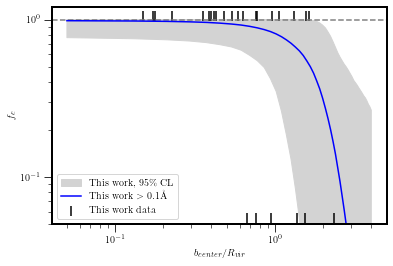

In [137]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(logb_norm, plow, phigh, color = 'lightgray', label = "This work, 95\% CL")
plt.plot(logb_norm, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(fc_G5_bcenter_norm.log_flux, fc_G5_bcenter_norm.outcomes+0.055, marker = "|", color = "black", s = 100, label = "This work data")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.05,1.2))
plt.yscale("log")
plt.xlabel("$b_{center}/ R_{vir}$")
plt.ylabel("$f_c$")
plt.xscale("log")

In [138]:
#pbest, plow, phigh = fc_G3_bmin_noz.predict_2d(logb, 1.0, params=fc_G3_bmin_noz.trace)

In [145]:
b = np.linspace(0,350, 100)

In [146]:
pbest, plow, phigh = fc_G5_bmin_noz.predict_2d(b, 1.0, params=fc_G5_bmin_noz.trace)

In [147]:
fc_cum = []
step = (b[1:] - b[:-1]).mean()
print(step)
for i in b:
    pbest_list = pbest[b<=i]
    fc_cum.append(pbest_list.sum()/(len(pbest_list)))

3.5353535353535355


In [151]:
pbest, plow, phigh = fc_G5_bmin_noz.predict_2d(logb, 1.0, params=fc_G5_bmin_noz.trace)

In [152]:
rr = Dutta_2020["R(kpc)"].tolist()
fcc = Dutta_2020["fc_groups"].tolist()
rr = np.array([0] + rr)
fcc = np.array([0] + fcc)
fcdiff = (fcc[1:]*rr[1:]**2 - fcc[:-1]*rr[:-1]**2)/(rr[1:]**2-rr[:-1]**2)
fcdiff
rrr = (rr[1:] + rr[:-1])/2

Text(0, 0.5, '$f_c$')

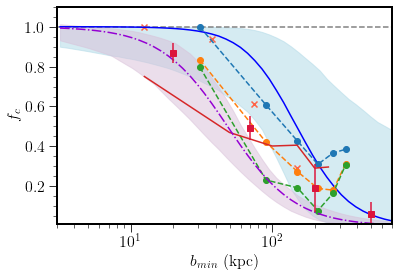

In [403]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
#plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.055, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)

#Dutta 2020
#plt.plot(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)
plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc01"], linestyle = "--", marker = "o", label = "Dutta 01")
plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc03"], linestyle = "--", marker = "o", label = "Dutta 03")
plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc1"], linestyle = "--", marker = "o", label = "Dutta 1")



plt.plot(rrr, fcdiff)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2021, $> 0.1$\AA")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
#plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
#plt.legend()
#plt.ylim((0.05,1.5))
#plt.xlim((2, 700))
plt.ylim((0.01,1.1))
plt.xlim((3, 700))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$f_c$")

In [400]:
Huang_2021

,b,all,all_sigma,blue,red
0,20.0,0.87,0.05,0.92,0.67
1,70.0,0.49,0.06,0.56,0.41
2,200.0,0.19,0.12,0.19,0.09
3,500.0,0.06,0.06,0.08,0.04


We would like to compare with Dutta 2020. For that we need to compute the cumulative covering fraction. A method would be to bin by impact parameter, and to count the number of absorbers. But it should be possible to do derive it directly from the differential fc. the differential fc is equivalent to :
\begin{equation}
fc = lim \frac{N_{abs}(b-db; b+db)}{N_{tot}(b-db; b+db)}
 \end{equation}
 
 The cumulative fc is:
 \begin{equation}
fc = lim \frac{N_{abs}(0; b)}{N_{tot}(0; b)}
 \end{equation}
 
 If we use bins. the cumulative fc is the sum of the differential fc with lower b.

In [161]:
pbest, plow, phigh = fc_G5_center_noz.predict_2d(logb, 1.0, params=fc_G5_bmin_noz.trace)

NameError: name 'fc_G5_center_noz' is not defined

NameError: name 'Schroetter_2020' is not defined

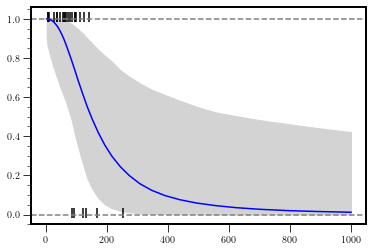

In [162]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightgray')
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.01, marker = "|", color = "black", s = 100)
#plt.scatter(np.log10(G3["b_min_kpc"]), G3["bool_absorption"])

#Dutta 2020
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.01,2))
plt.xlim((1, 500))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$f_c$")

In [ ]:
r = np.linspace(1, 300, 100)*u.kpc
gid.NFW_escape_vel_from_Mvir(r, 1e12*u.solMass, z = 1)

In [ ]:
gid.plot_groups_2(R, G5, Nmin = 5, save = True, filename = "group_catalog.pdf")

# Additional plots

In [ ]:

plt.hist(Abs["z_abs"]);
plt.hist(G5_raw["center_z"], range = (0,4), bins = 4*4);

In [ ]:
field_lst = Abs["field_name"].unique()

In [ ]:
Abs.columns

In [ ]:
oii = 3737
mgii = 2796
uves_min = 3000
uves_max = 11000
muse_min = 4700
muse_max = 9350
zmin_oii = muse_min/oii - 1 
zmax_oii = muse_max/oii - 1
zmin_mgii = uves_min/mgii - 1 
zmax_mgii = uves_max/mgii - 1

In [ ]:
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelleft']=False
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=0
plt.rcParams['ytick.major.size']=0
plt.rcParams['ytick.left']= False
plt.rcParams['ytick.major.left']= False

In [ ]:
fig = plt.figure(figsize = (8,22*0.5))

i = 1
for f in field_lst:
    plt.subplot(22, 1, i)
    plt.subplots_adjust(wspace=0, hspace=0)
    ab = Abs[Abs["field_name"] == f]
    ab = ab[ab["REW_2796"]>=0.1]
    qso = fields_info[fields_info["field_id"] == f]
    grp = G5_raw[G5_raw["field_id"] == f]
    plt.scatter(grp["center_z"], grp["center_z"]/grp["center_z"], marker = "o", \
                  s = 70, color = "lightsteelblue", edgecolors = "b")
    plt.hlines(y = 1, xmin = 0, xmax = qso["zqso_sdss"], linestyle = ":", color = "r")
    plt.scatter(ab["z_abs"], ab["z_abs"]/ab["z_abs"], marker = "|", s = 300, c = "r")
    plt.scatter(qso["zqso_sdss"], qso["zqso_sdss"]/qso["zqso_sdss"], marker = "*", c = "r", s = 80)
    #plt.yticks = [1.0]
    plt.xticks(ticks = [0., 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5])
    plt.xlim((-0.8,3.1))
    plt.axvline(zmin_oii, linestyle = ":", c = "blue", linewidth = 2)
    plt.axvline(zmax_oii, linestyle = ":", c = "blue", linewidth = 2)
    plt.axvline(zmin_mgii, linestyle = ":", c = "green", linewidth = 2)
    plt.axvline(zmax_mgii, linestyle = ":", c = "green", linewidth = 2)
    plt.axvline(0, c = "black")
    plt.text(-0.8, 0.98, f, fontsize=18)
    
    
    i += 1
plt.xlabel("z")

In [ ]:
plt.figure()
plt.tick_params(left = False, bottom = False)
plt.scatter([12,42,32,59,8],[18,39,20,19,44])
plt.text(0,0,"hello", fontsize = 14, transform=transAxes)

In [ ]:
3727*(1+0.988)

In [ ]:
const.c.to(u.km/u.s)

In [ ]:
gid.plot_groups(R, G, Nmin = 5)

In [ ]:
grp = G5[G5["ID"] == 10]
grp

In [ ]:
rr = R[R["group"] == 267]
rr[["ID", "Psat"]]

In [ ]:
plt.scatter(rr["r_to_gcenter"], rr["vlos_to_gcenter"], c = rr["Psat"], vmin = 0, vmax = 1)

In [ ]:
GG = G[G["N_gal"]>=5]
GG = GG[["ID", "group_id", "field_id", "center_z", "mean_z", "vlos_spread", "z_min", "z_max", "lambda_oii_a"]]
GG["min_oii"] = 3727*(1+GG["z_min"])
GG["max_oii"] = 3727*(1+GG["z_max"])
GG

In [ ]:
GG.to_csv("G5_for_oii_maps2.csv", index = False)

In [ ]:
R[R["group"] == 190]

In [ ]:
G.columns

In [ ]:
G[["field_id", "ID",  "N_gal", "REW_2796", "center_z", "zqso_sdss","QSO_is_behind"]].head(30)

In [ ]:
G3.head(50)

In [ ]:
plt.scatter(G5["REW_2796"], np.log10(G5["M_vel_disp"]))

In [ ]:
alpha -4.8 [-11.74--0.53] (95\%) 
beta 2.1 [1.54-2.85] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.7 - 4.8)
print(0.53-4.8)

In [ ]:
print(2.1 - 1.54)
print(2.85-2.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
print(0.6 - 0.04)
print(0.6 - 0.98)

In [ ]:
alpha -4.6 [-11.38--0.45] (95\%) 
beta 1.1 [0.63-2.43] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.38 - 4.6)
print(0.45 - 4.6)

In [ ]:
print(1.1 - 0.63)
print(2.43-1.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
gid.plot_groups_2(R, G5)

In [ ]:
len(G5)

In [523]:
G5

,index,field_id,group_id,N_gal,mean_z,mean_ra,mean_dec,b_min_kpc,Mvir_sigma2,Mvir_sigma3,...,vlos_min,vlos_max,z_min,z_max,vlos_spread,Vvir_sigma2,Vvir_sigma3,bool_abs_01,bool_abs_03,bool_abs_1
1,1,J1039p0714,617,21,0.987775,159.902073,7.241364,46.37,7.630926e+12,4.314044e+12,...,-441.702613,244.217827,0.98572,0.99027,685.920440,325.717939,269.325481,1,1,0
2,2,J0014m0028,1300,13,0.831174,3.720720,-0.478020,7.77,5.236328e+13,9.596833e+13,...,-1281.800164,456.150824,0.82581,0.83644,1737.950988,597.345475,731.014423,1,1,1
3,3,J1107p1021,555,11,0.744963,166.927579,10.358156,36.59,7.722912e+11,2.982841e+11,...,-147.745332,97.924232,0.74418,0.74561,245.669563,143.531899,104.527707,1,1,1
4,4,J1107p1021,560,10,0.901378,166.924563,10.352484,93.01,1.601219e+12,7.174214e+11,...,-64.666871,212.927501,0.90033,0.90209,277.594372,189.840760,145.266014,0,0,0
5,5,J0058p0111,1089,9,0.637238,14.734247,1.191987,6.06,2.384780e+12,1.321890e+12,...,-128.849331,241.044702,0.63647,0.63849,369.894034,203.572837,167.225343,1,1,1
6,6,J1352p0614,322,8,0.606026,208.074382,6.240785,10.36,1.045701e+13,1.385262e+13,...,-398.778045,330.949725,0.60420,0.60811,729.727770,330.604695,363.092424,1,1,0
7,7,J1509p1506,115,7,0.970296,227.249908,15.113088,79.59,5.258401e+12,2.862130e+12,...,-509.354642,0.000000,0.96837,0.97172,509.354642,286.584491,233.990307,1,1,1
9,9,J1358p1145,253,7,1.099736,209.533852,11.773288,253.48,1.918422e+12,1.373406e+12,...,-233.456112,144.863275,1.09831,1.10096,378.319388,210.617359,188.413694,0,0,0
10,10,J1236p0725,446,7,1.331220,189.099584,7.427450,113.48,2.852294e+12,1.340744e+12,...,-234.050693,131.085695,1.32994,1.33278,365.136388,252.025875,195.957692,1,1,0
11,11,J2152p0625,13,7,1.432120,328.002607,6.422932,60.96,1.322800e+13,8.333232e+12,...,-303.951577,442.976323,1.42982,1.43588,746.927900,428.557489,367.380021,1,1,1


,field_name,z_abs,REW_2796,sig_REW_2796,N2000_abs,bmin2000_abs
0,J0014m0028,0.24629,1.401,0.041,0,NaN
1,J0014m0028,0.58576,0.715,0.027,3,18.51
2,J0014m0028,0.65692,2.286,0.023,5,74.58
3,J0014m0028,0.82551,0.127,0.019,5,51.34
4,J0014m0028,0.83403,2.085,0.016,8,7.77
...,...,...,...,...,...,...
121,J2137p0012,1.30017,0.108,0.015,2,102.24
122,J2152p0625,1.05324,0.518,0.035,2,49.92
123,J2152p0625,1.17623,0.498,0.034,0,NaN
124,J2152p0625,1.31921,1.413,0.026,2,19.46


In [549]:
Abs = gid.get_N100_abs(Abs, R, dv = 0.5e6)
G5_1 = G5[["field_id", "group_id", "N_gal", "center_z", "b_center_kpc"]]
G5_2 = G5_1.copy()
G5_3 = G5_1.copy()

In [565]:
G5_1 = gid.match_absorptions(G5_1, Abs, dv = 0.01e6)
G5_2 = gid.match_absorptions(G5_2, Abs, dv = 0.4e6)
G5_3 = gid.match_absorptions(G5_3, Abs, dv = 5e6)

print(len(G5_1[G5_1["bool_absorption"] == 1]))
print(len(G5_2[G5_2["bool_absorption"] == 1]))
print(len(G5_3[G5_3["bool_absorption"] == 1]))

2
21
21


In [539]:
G5_1.columns

Index(['field_id', 'group_id', 'N_gal', 'center_z', 'b_center_kpc', 'REW_2796',
       'sig_REW_2796', 'z_absorption', 'z_absorption_dist',
       'vel_absorption_dist', 'N100_abs', 'bool_absorption'],
      dtype='object')

In [541]:
G5_1[["group_id", "bool_absorption"]]

,group_id,bool_absorption
1,617,1
2,1300,1
3,555,1
4,560,0
5,1089,1
6,322,1
7,115,1
9,253,0
10,446,1
11,13,1


In [566]:
for c in R.columns:
    print(c)

ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
white_ID
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_i
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
mass_noNA
mass
dist_ang
dist_lum
N100_neighb
N50_neighb
group_id
DMEAN
D12
V12
is_grouped
Mvir_sigma2
Mvir_sigma3
Rvir_sigma2
Rvir_sigma3
mass10
ra_mass
dec_mass
z_mass
Mvir

# uncertainties on velocities

In [581]:
dlambda = 1.25 #Angstrom, the spectral pixel in MUSE is 1.25A
z = 1
dz = (4700*(1+z)+dlambda)/4700 - 1-z
print(dz)
dv = const.c*dz/(1+z)
print(dv)

0.0002659574468086845
39866.01835108989 m / s


In [582]:
R[[]]

,ID,field_id,DATASET,FROM,Z,ZCONF,is_QSO,is_star,DR1_id,DR1_nbmatch,...,z_absorption,z_absorption_dist,vel_absorption_dist,bool_absorption,QSO_is_behind,OII_FLUX,SFR_from_OII,N2000_neighb,Mvir,Rvir
0,11001,J0014m0028,b'beta',b'FELINE',1.92000,3,1,0,NaN,NaN,...,0.0,0,0.0,0,False,NaN,NaN,0,NaN,NaN
1,32081,J2152p0625,b'psfsub',b'FELINE',0.87357,3,0,0,NaN,NaN,...,0.0,0,0.0,0,True,5.250172e+41,8.220842,0,11.669406,128.353235
2,32076,J2152p0625,b'psfsub',b'FELINE',1.01279,2,0,0,NaN,NaN,...,0.0,0,0.0,0,True,3.092236e+40,NaN,2,NaN,NaN
3,32080,J2152p0625,b'psfsub',b'FELINE',1.01400,3,0,0,NaN,NaN,...,0.0,0,0.0,0,True,1.737688e+42,33.080249,2,11.790799,132.288610
4,32051,J2152p0625,b'psfsub',b'FELINE',1.01310,3,0,0,NaN,NaN,...,0.0,0,0.0,0,True,3.712510e+41,4.367386,2,11.599639,114.280877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,11137,J0014m0028,b'psfsub',b'FELINE',1.39793,3,0,0,NaN,NaN,...,0.0,0,0.0,0,True,6.446056e+41,13.444913,4,11.931390,125.895030
2016,11179,J0014m0028,b'psfsub',b'FELINE',1.39893,2,0,0,NaN,NaN,...,0.0,0,0.0,0,True,4.741357e+40,NaN,4,NaN,NaN
2017,11142,J0014m0028,b'psfsub',b'FELINE',1.39643,3,0,0,NaN,NaN,...,0.0,0,0.0,0,True,1.487325e+41,1.810311,4,11.734078,108.265049
2018,11155,J0014m0028,b'psfsub',b'FELINE',1.39900,2,0,0,NaN,NaN,...,0.0,0,0.0,0,True,1.790004e+41,2.303534,4,11.760001,110.331784
